# <font color='blue'>Trabalho Prático 2 - Planejamento e Navegação</font>
# <font color='blue'>Passo 1a: Roadmaps - Kuka Youbot</font>

### <font color='blue'>Weber Vieira de Souza</font>
### <font color='blue'>2025719242</font>

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.5


In [ ]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
%pip install -q -U watermark

In [ ]:
# https://pypi.org/project/gradio/
# https://pypi.org/project/Shapely/
# pip install -q shapely
# conda install --channel conda-forge shapely
# pip install -q descartes
%pip install -q numpy shapely networkx scipy matplotlib random descartes coppeliasim-zmqremoteapi-client

In [2]:
# Imports
import time
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Point, LineString, Polygon     # type: ignore
from descartes.patch import PolygonPatch
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

from collections import deque
from scipy.spatial import KDTree, distance

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Weber Souza" --iversions

Author: Weber Souza

coppeliasim_zmqremoteapi_client: 2.0.4
scipy                          : 1.11.1
shapely                        : 2.1.2
platform                       : 1.0.8
networkx                       : 3.1
descartes                      : 1.1.0
numpy                          : 1.24.3
matplotlib                     : 3.7.2



## Matrizes de Transformação Homogênea

In [4]:
# Conecta com o CoppeliaSim
client = RemoteAPIClient()
sim = client.require("sim")
sim.setStepping(True)

0

### Definição dos Parâmetros do Robô

In [5]:
# Parâmetros do Kuka youbot
ROBOT_RADIUS = 0.2  # raio do robô em metros
SAFETY_MARGIN = 0.1  # margem de segurança adicional
EFFECTIVE_RADIUS = ROBOT_RADIUS + SAFETY_MARGIN

In [6]:
# Carregar mapas
mapa1 = mpimg.imread('Imagens/mapa1_invertido.png')
mapa2 = mpimg.imread('Imagens/mapa2_invertido.png')

# Dimensões dos mapas (assumindo escala conhecida)
WORLD_WIDTH = 50  # largura em metros
WORLD_HEIGHT = 30  # altura em metros

In [7]:
# Converte coordenadas de pixel para coordenadas do mundo.
def pixel_to_world(px, py, img_shape, world_width, world_height):
    h, w = img_shape[:2]
    x = (px / w) * world_width
    y = (py / h) * world_height
    return x, y

In [8]:
# Converte coordenadas do mundo para coordenadas de pixel.
def world_to_pixel(x, y, img_shape, world_width, world_height):
    h, w = img_shape[:2]
    px = int((x / world_width) * w)
    py = int((y / world_height) * h)
    return px, py

In [9]:
# Verifica se o caminho entre dois pontos está livre de colisões.
def is_collision_free(x1, y1, x2, y2, mapa, robot_radius, world_width, world_height):
    num_checks = int(distance.euclidean([x1, y1], [x2, y2]) * 10)
    num_checks = max(num_checks, 10)
    
    for i in range(num_checks + 1):
        t = i / num_checks
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        
        px, py = world_to_pixel(x, y, mapa.shape, world_width, world_height)
        
        # Verificar área ao redor do ponto considerando o raio do robô
        radius_px = int((robot_radius / world_width) * mapa.shape[1])
        
        for dx in range(-radius_px, radius_px + 1):
            for dy in range(-radius_px, radius_px + 1):
                check_px = px + dx
                check_py = py + dy
                
                if 0 <= check_px < mapa.shape[1] and 0 <= check_py < mapa.shape[0]:
                    if mapa[check_py, check_px, 0] < 0.5:  # obstáculo
                        return False
    return True

In [10]:
# Gera amostras aleatórias no espaço livre
def generate_random_samples(mapa, num_samples, robot_radius, world_width, world_height):
    samples = []
    attempts = 0
    max_attempts = num_samples * 100
    
    while len(samples) < num_samples and attempts < max_attempts:
        x = np.random.uniform(0, world_width)
        y = np.random.uniform(0, world_height)
        
        px, py = world_to_pixel(x, y, mapa.shape, world_width, world_height)
        
        # Verificar se o ponto está livre
        radius_px = int((robot_radius / world_width) * mapa.shape[1])
        is_free = True
        
        for dx in range(-radius_px, radius_px + 1):
            for dy in range(-radius_px, radius_px + 1):
                check_px = px + dx
                check_py = py + dy
                
                if 0 <= check_px < mapa.shape[1] and 0 <= check_py < mapa.shape[0]:
                    if mapa[check_py, check_px, 0] < 0.5:
                        is_free = False
                        break
            if not is_free:
                break
        
        if is_free:
            samples.append((x, y))
        
        attempts += 1
    
    return samples

In [11]:
# Encontra o caminho mais curto no grafo usando A*
def find_path(G, start_idx, goal_idx):
    try:
        path_indices = nx.astar_path(G, start_idx, goal_idx, weight='weight')
        return path_indices
    except nx.NetworkXNoPath:
        return None

In [12]:
# Constrói o grafo roadmap conectando amostras próximas
def build_roadmap(samples, start, goal, mapa, robot_radius, world_width, world_height, k_nearest=10):
    G = nx.Graph()
    
    # Adicionar todos os pontos incluindo início e objetivo
    all_points = [start] + samples + [goal]
    
    for i, point in enumerate(all_points):
        G.add_node(i, pos=point)
    
    # Conectar cada ponto aos k vizinhos mais próximos
    for i, p1 in enumerate(all_points):
        distances = []
        for j, p2 in enumerate(all_points):
            if i != j:
                dist = distance.euclidean(p1, p2)
                distances.append((j, dist))
        
        # Ordenar por distância e pegar os k mais próximos
        distances.sort(key=lambda x: x[1])
        
        for j, dist in distances[:k_nearest]:
            p2 = all_points[j]
            if is_collision_free(p1[0], p1[1], p2[0], p2[1], mapa, robot_radius, world_width, world_height):
                G.add_edge(i, j, weight=dist)
    
    return G, all_points

### Experimento 1: Mapa 1 - Cenário Simples

In [13]:
# Simulacao
sim.startSimulation()
try:
    # Definir pontos de início e objetivo para Mapa 1
    start_mapa1 = (5, 15)
    goal_mapa1 = (45, 15)

    # Gerar amostras
    num_samples = 200
    samples_mapa1 = generate_random_samples(mapa1, num_samples, EFFECTIVE_RADIUS, WORLD_WIDTH, WORLD_HEIGHT)

    print(f"Amostras geradas: {len(samples_mapa1)}")

    # Construir roadmap
    G_mapa1, all_points_mapa1 = build_roadmap(samples_mapa1, start_mapa1, goal_mapa1, mapa1, 
                                            EFFECTIVE_RADIUS, WORLD_WIDTH, WORLD_HEIGHT, k_nearest=15)

    print(f"Grafo construído com {G_mapa1.number_of_nodes()} nós e {G_mapa1.number_of_edges()} arestas")

    # Encontrar caminho
    path_indices_mapa1 = find_path(G_mapa1, 0, len(all_points_mapa1) - 1)

    if path_indices_mapa1:
        path_mapa1 = [all_points_mapa1[i] for i in path_indices_mapa1]
        path_length_mapa1 = sum([distance.euclidean(path_mapa1[i], path_mapa1[i+1]) 
                                for i in range(len(path_mapa1)-1)])
        print(f"Caminho encontrado com comprimento: {path_length_mapa1:.2f} m")
    else:
        print("Nenhum caminho encontrado")
except Exception as e:
    print(f"An error occurred: {e}")
    
sim.stopSimulation()
print('Simulação Parada')

Amostras geradas: 200
Grafo construído com 202 nós e 982 arestas
Caminho encontrado com comprimento: 45.98 m
Simulação Parada


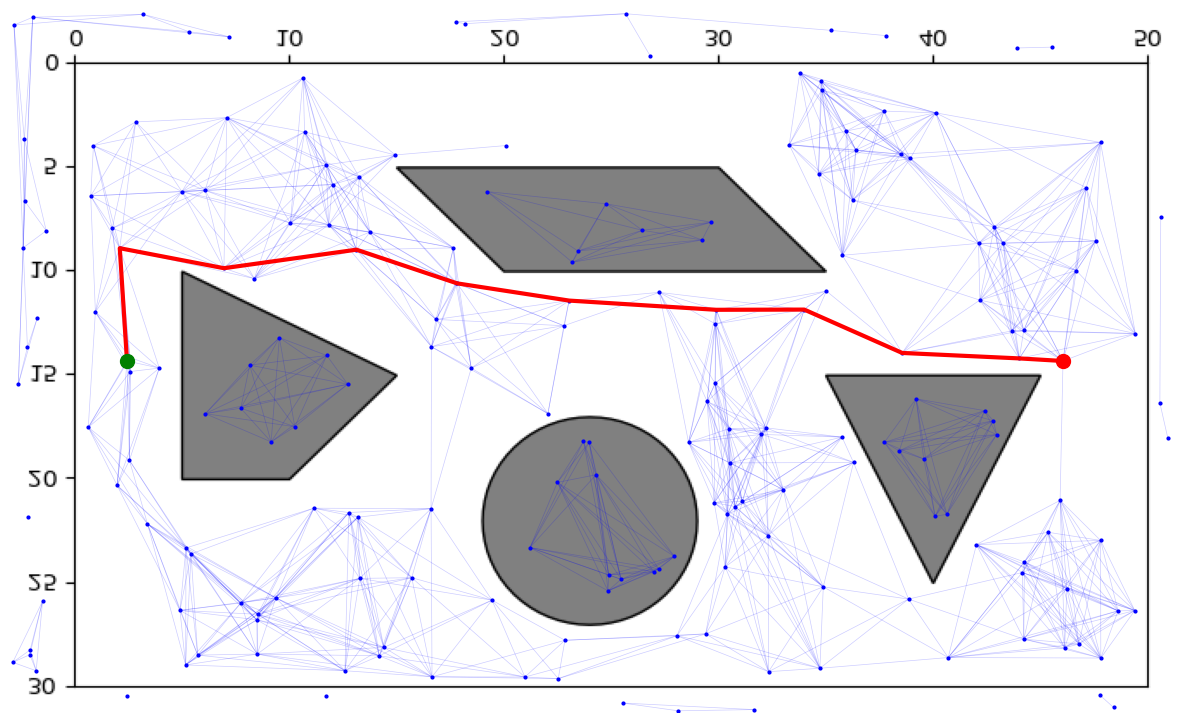

In [14]:
if path_indices_mapa1:
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(mapa1, extent=[0, WORLD_WIDTH, 0, WORLD_HEIGHT], origin='lower')
    
    # Desenhar grafo
    for edge in G_mapa1.edges():
        p1 = all_points_mapa1[edge[0]]
        p2 = all_points_mapa1[edge[1]]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', alpha=0.2, linewidth=0.5)
    
    # Desenhar amostras
    for point in samples_mapa1:
        ax.plot(point[0], point[1], 'bo', markersize=2)
    
    # Desenhar caminho
    path_x = [p[0] for p in path_mapa1]
    path_y = [p[1] for p in path_mapa1]
    ax.plot(path_x, path_y, 'r-', linewidth=3)
    
    # Desenhar início e objetivo
    ax.plot(start_mapa1[0], start_mapa1[1], 'go', markersize=10)
    ax.plot(goal_mapa1[0], goal_mapa1[1], 'ro', markersize=10)
    
    ax.set_xlim(0, WORLD_WIDTH)
    ax.set_ylim(0, WORLD_HEIGHT)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('Imagens/roadmap_mapa1_youbot.png', dpi=150, bbox_inches='tight')
    plt.show()

### Experimento 2: Mapa 2 - Cenário Complexo

In [17]:
# Simulacao
sim.startSimulation()
try:
    # Definir pontos de início e objetivo para Mapa 2
    start_mapa2 = (5, 5)
    goal_mapa2 = (10, 15)

    # Gerar mais amostras para o mapa mais complexo
    num_samples_2 = 200
    samples_mapa2 = generate_random_samples(mapa2, num_samples_2, EFFECTIVE_RADIUS, WORLD_WIDTH, WORLD_HEIGHT)

    print(f"Amostras geradas: {len(samples_mapa2)}")

    # Construir roadmap
    G_mapa2, all_points_mapa2 = build_roadmap(samples_mapa2, start_mapa2, goal_mapa2, mapa2, 
                                            EFFECTIVE_RADIUS, WORLD_WIDTH, WORLD_HEIGHT, k_nearest=15)

    print(f"Grafo construído com {G_mapa2.number_of_nodes()} nós e {G_mapa2.number_of_edges()} arestas")

    # Encontrar caminho
    path_indices_mapa2 = find_path(G_mapa2, 0, len(all_points_mapa2) - 1)

    if path_indices_mapa2:
        path_mapa2 = [all_points_mapa2[i] for i in path_indices_mapa2]
        path_length_mapa2 = sum([distance.euclidean(path_mapa2[i], path_mapa2[i+1]) 
                                for i in range(len(path_mapa2)-1)])
        print(f"Caminho encontrado com comprimento: {path_length_mapa2:.2f} m")
    else:
        print("Nenhum caminho encontrado")
except Exception as e:
    print(f"An error occurred: {e}")
    
sim.stopSimulation()
print('Simulação Parada')

An error occurred: too many indices for array: array is 2-dimensional, but 3 were indexed
Simulação Parada


In [ ]:
if path_indices_mapa2:
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(mapa2, extent=[0, WORLD_WIDTH, 0, WORLD_HEIGHT], origin='lower')
    
    # Desenhar grafo
    for edge in G_mapa2.edges():
        p1 = all_points_mapa2[edge[0]]
        p2 = all_points_mapa2[edge[1]]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', alpha=0.2, linewidth=0.5)
    
    # Desenhar amostras
    for point in samples_mapa2:
        ax.plot(point[0], point[1], 'bo', markersize=2)
    
    # Desenhar caminho
    path_x = [p[0] for p in path_mapa2]
    path_y = [p[1] for p in path_mapa2]
    ax.plot(path_x, path_y, 'r-', linewidth=3)
    
    # Desenhar início e objetivo
    ax.plot(start_mapa2[0], start_mapa2[1], 'go', markersize=10)
    ax.plot(goal_mapa2[0], goal_mapa2[1], 'ro', markersize=10)
    
    ax.set_xlim(0, WORLD_WIDTH)
    ax.set_ylim(0, WORLD_HEIGHT)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('Imagens/roadmap_mapa2_youbot.png', dpi=150, bbox_inches='tight')
    plt.show()

# Fim